In [1]:
import numpy as np
import libpysal as ps
import geopandas as gp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mapclassify
import esda
import contextily as ctx

In [2]:
# Modeling done in the R Script, this is just reading a table that contains the residuals as well

# Split 1
houses = pd.read_csv(r"Y:\Lukas\thesis\bus1123\randomsample_houses\0124-cali_GWRF_res-1.csv")

# Split 2
#houses = pd.read_csv(r"Y:\Lukas\thesis\bus1123\randomsample_houses\0124-cali_GWRF_res-2.csv")

# Split 3
#houses = pd.read_csv(r"Y:\Lukas\thesis\bus1123\randomsample_houses\0124-cali_GWRF_res-3.csv")

In [3]:
housesgdf = gp.GeoDataFrame(
    houses, geometry=gp.points_from_xy(houses.lon, houses.lat), crs="EPSG:3310"
)

In [4]:
housesgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   MedHouseVa            411 non-null    float64 
 1   MedIncome             411 non-null    float64 
 2   MedianAge             411 non-null    int64   
 3   Population            411 non-null    int64   
 4   Households            411 non-null    int64   
 5   roomsperHH            411 non-null    float64 
 6   bedroomHH             411 non-null    float64 
 7   lat                   411 non-null    float64 
 8   lon                   411 non-null    float64 
 9   MedHouseVa_Predicted  411 non-null    float64 
 10  Residuals             411 non-null    float64 
 11  geometry              411 non-null    geometry
dtypes: float64(8), geometry(1), int64(3)
memory usage: 38.7 KB


In [5]:
housesgdf.head(3)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,lat,lon,MedHouseVa_Predicted,Residuals,geometry
0,55000.0,1.6071,27,587,231,4.190476,1.038961,-116314.796314,-6223.359080,65525.693333,-10525.693333,POINT (-6223.359 -116314.796)
1,104200.0,2.1250,16,1077,520,5.046154,1.013462,-192791.956595,60108.280241,77458.676667,26741.323333,POINT (60108.280 -192791.957)
2,176100.0,2.9000,20,1607,564,4.083333,1.085106,-459723.034567,186008.732382,205001.550000,-28901.550000,POINT (186008.732 -459723.035)


<Axes: >

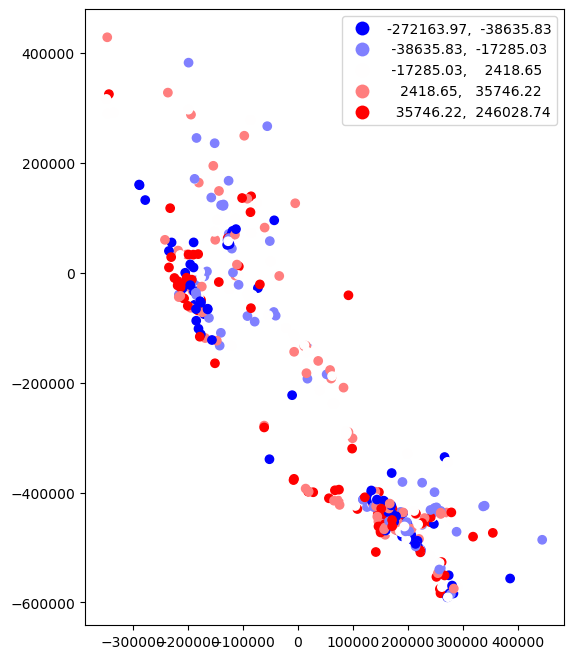

In [6]:
# plot residuals
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
housesgdf.plot(column='Residuals', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

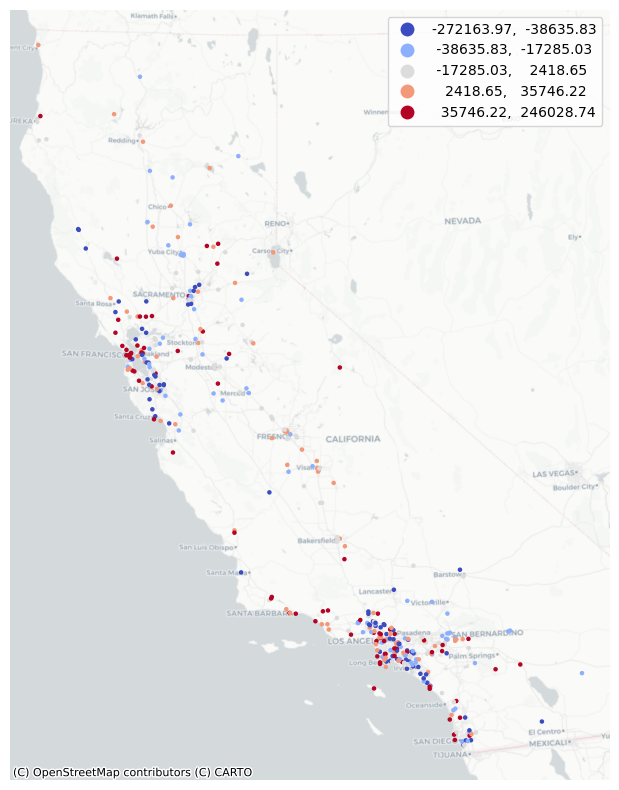

In [7]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': 'equal'})
housesgdf.plot(column='Residuals', scheme='Quantiles', k=5, cmap='coolwarm', legend=True, ax=ax, markersize=5)
ctx.add_basemap(ax, crs=housesgdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/basemap_GWRF.png'
#plt.savefig(save_path)
plt.show()

In [8]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(housesgdf, k=6) 
wi.transform = 'r'
y = housesgdf['Residuals']

In [9]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), '; p-value is', mi.p_sim, '; expected value is', mi.EI)

Moran I is 0.12 ; p-value is 0.000999000999000999 ; expected value is -0.0024390243902439024


In [10]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [11]:
# Calculate spatial groupings and significance
housesgdf['Is'] = lisa.Is
housesgdf['pvalue'] = lisa.p_sim 
housesgdf['group'] = lisa.q 
housesgdf.loc[housesgdf['pvalue'] > 0.05, 'group'] = 'not-significant'
housesgdf.loc[housesgdf['group'] == 1, 'group'] = 'hotspot'
housesgdf.loc[housesgdf['group'] == 2, 'group'] = 'cold outlier'
housesgdf.loc[housesgdf['group'] == 3, 'group'] = 'coldspot'
housesgdf.loc[housesgdf['group'] == 4, 'group'] = 'hot outlier'
print(housesgdf ['group'].value_counts())
housesgdf.head(2)

group
not-significant    352
hotspot             24
coldspot            17
cold outlier        11
hot outlier          7
Name: count, dtype: int64


C:\Users\lukasb97\AppData\Local\Temp\ipykernel_15632\4266215576.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'not-significant' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  housesgdf.loc[housesgdf['pvalue'] > 0.05, 'group'] = 'not-significant'


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,lat,lon,MedHouseVa_Predicted,Residuals,geometry,Is,pvalue,group
0,55000.0,1.6071,27,587,231,4.190476,1.038961,-116314.796314,-6223.359080,65525.693333,-10525.693333,POINT (-6223.359 -116314.796),-0.009860,0.404,not-significant
1,104200.0,2.1250,16,1077,520,5.046154,1.013462,-192791.956595,60108.280241,77458.676667,26741.323333,POINT (60108.280 -192791.957),0.028232,0.415,not-significant


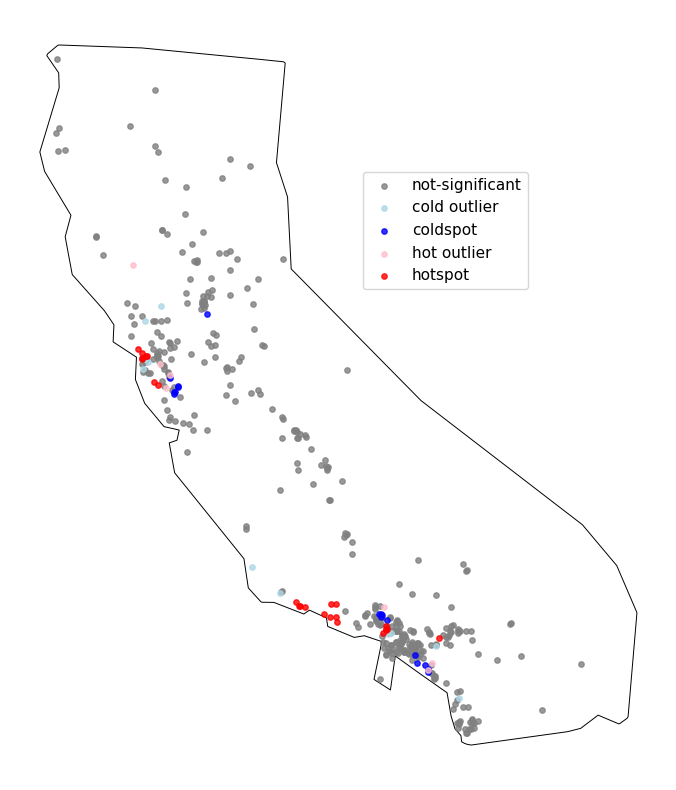

In [12]:
# Vizualize spatial groupings and significance
state_boundary = gpd.read_file(r"Y:/Lukas/thesis/bus1123/bufferedcliprahmen.shp")
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
#group_colors
state_boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, facecolor='none')

for ctype, data in housesgdf.groupby('group'):
    if ctype == 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

for ctype, data in housesgdf.groupby('group'):
    if ctype != 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

ax.legend(bbox_to_anchor=(0.8, .8), prop={'size': 11})

ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/lisa_GWRF_S2_small.png'
#plt.savefig(save_path)
plt.show()